In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
df = pd.read_csv("daily-min-temperatures.csv", header=0, index_col=0, parse_dates=True)
df.rename(columns={"Temp": "Temperature"}, inplace=True)  # Rename column if needed

# Display first few rows
df.head()


,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


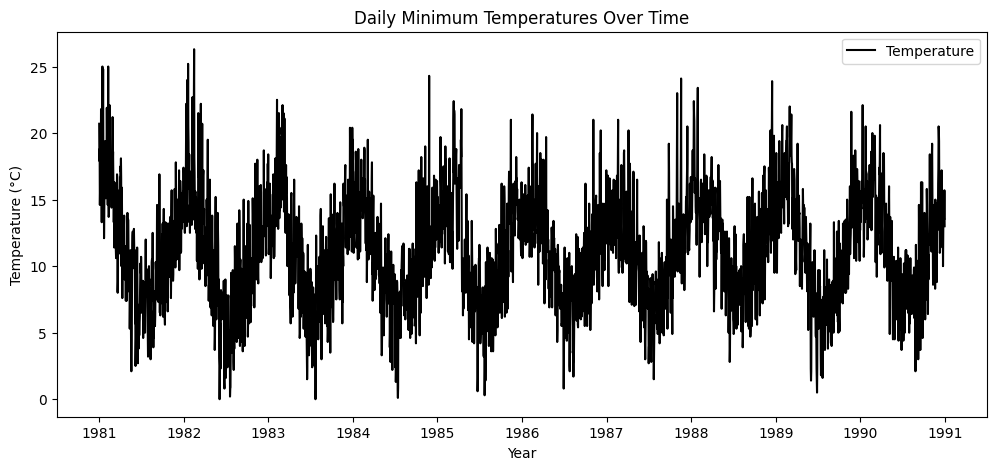

In [3]:
# Plot the original time series
plt.figure(figsize=(12, 5))
plt.plot(df, label="Temperature", color="black")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Daily Minimum Temperatures Over Time")
plt.legend()
plt.show()


In [4]:
# Perform Augmented Dickey-Fuller (ADF) Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is NOT stationary. Differencing may be required.")

adf_test(df["Temperature"])


ADF Statistic: -4.444804924611686
p-value: 0.00024708263003611256
Critical Values: {'1%': -3.4321532327220154, '5%': -2.862336767636517, '10%': -2.56719413172842}
The time series is stationary.


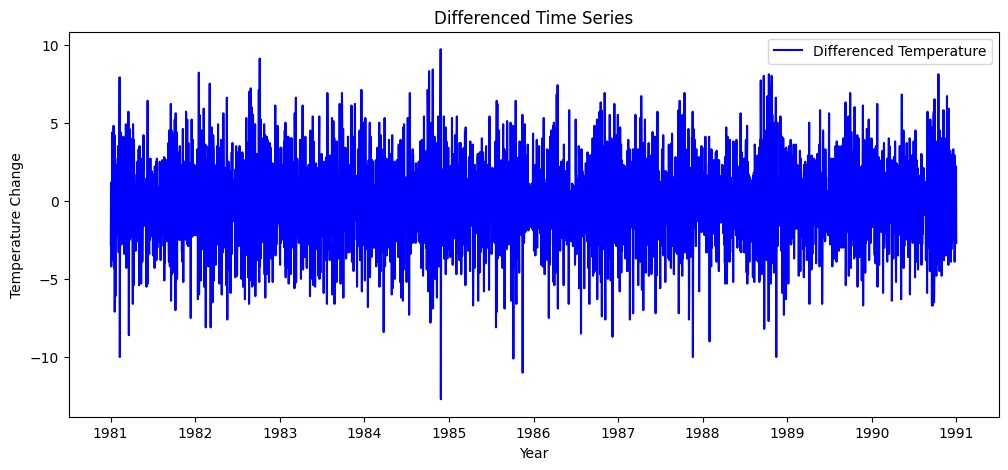

ADF Statistic: -18.02822416799208
p-value: 2.6815618226750238e-30
Critical Values: {'1%': -3.432155722391455, '5%': -2.8623378673761084, '10%': -2.567194717193812}
The time series is stationary.


In [5]:
# Apply first-order differencing if the series is non-stationary
df_diff = df.diff().dropna()

# Plot the differenced time series
plt.figure(figsize=(12, 5))
plt.plot(df_diff, label="Differenced Temperature", color="blue")
plt.xlabel("Year")
plt.ylabel("Temperature Change")
plt.title("Differenced Time Series")
plt.legend()
plt.show()

# Re-run ADF test on differenced data
adf_test(df_diff["Temperature"])


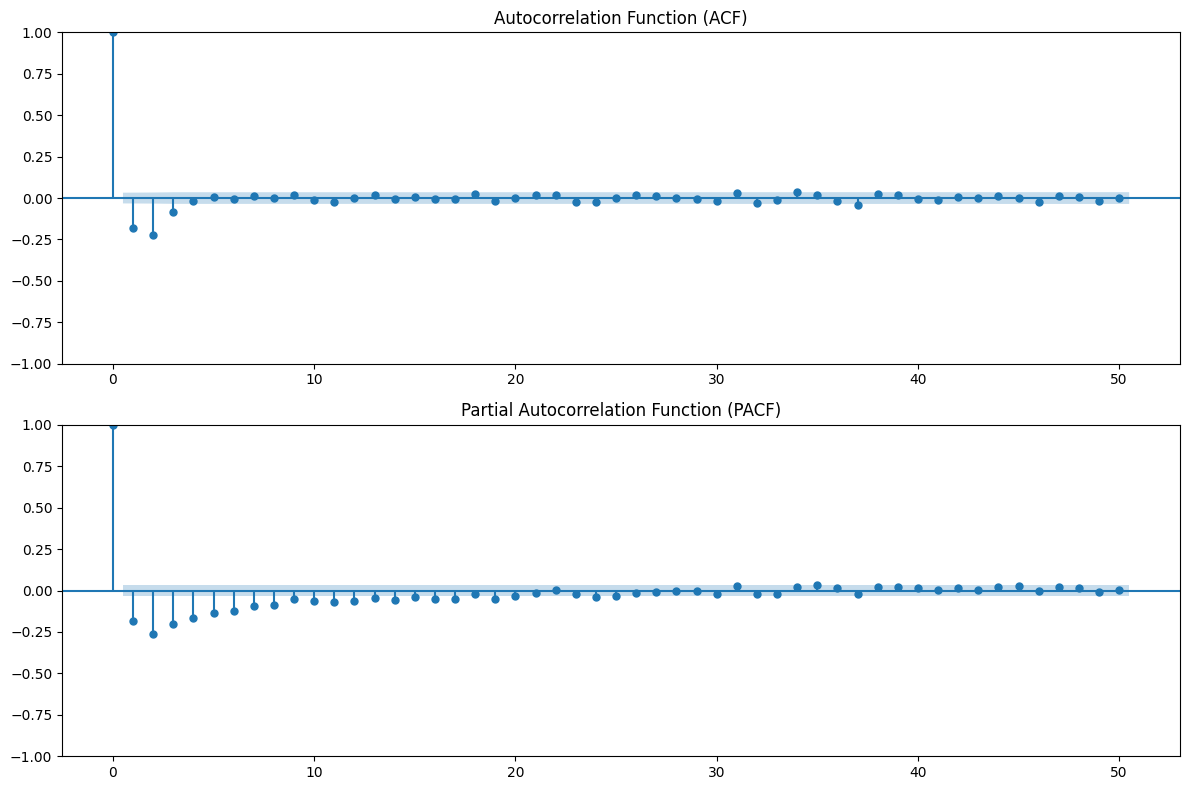

In [6]:
# Plot ACF and PACF to determine lag values
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_diff, ax=ax[0], lags=50)  # ACF plot
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(df_diff, ax=ax[1], lags=50, method="ols")  # PACF plot
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("daily-min-temperatures.csv", index_col=0, parse_dates=True)
y = df.iloc[:, 0]  # Selecting the first column as the time series data

# Calculate the mean of y
mu = y.mean()

In [12]:
acf_list_alt = []

for lag in range(0, 11):
    acf_list_alt.append(sum((y - mu).iloc[lag:] * (y.shift(lag) - mu).iloc[lag:]) / sum((y - mu) ** 2))

print("Alternative manual ACF values:", np.array(acf_list_alt))


Alternative manual ACF values: [1.         0.774268   0.6302866  0.58529312 0.57774567 0.57728013
 0.57510412 0.57437039 0.56782622 0.56120131 0.54668689]


In [13]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression

# Compute PACF using statsmodels
pacf_values = pacf(df.squeeze(), nlags=10, method="ols")
print("Partial Autocorrelation values:", pacf_values)


Partial Autocorrelation values: [1.         0.77431043 0.07708886 0.19018211 0.15130926 0.13038339
 0.10963739 0.10344817 0.07499019 0.07243249 0.03634852]


In [14]:
N_LAGS = 10
pacf_list = [1]  # The first partial autocorrelation is always 1

X = pd.DataFrame(lagmat(y, N_LAGS))
X.columns = [f"lag_{lag+1}" for lag in range(N_LAGS)]

for k in range(1, N_LAGS + 1):
    fitted_model = LinearRegression().fit(X.iloc[k:, :k], y.iloc[k:])
    pacf_list.append(fitted_model.coef_[-1])

print("Manual PACF values:", np.array(pacf_list))


Manual PACF values: [1.         0.77431043 0.07708886 0.19018211 0.15130926 0.13038339
 0.10963739 0.10344817 0.07499019 0.07243249 0.03634852]
